# InternVL3-8B: 2-Turn Balance-Description Bank Statement Extraction

**Protocol**: Two independent single-turn prompts + Python parsing/filtering

**Key Insight**: Balance-description prompt works for BOTH date-per-row AND date-grouped formats!

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
        ↓ (Check if Balance column exists)
Turn 1: Image + Prompt → Balance-Description extraction (fresh context)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Why Balance-Description Works:
- **Anchors extraction to Balance column** - unambiguous reference point
- **Works for date-per-row**: Each transaction gets its date
- **Works for date-grouped**: Date headers naturally map to transactions
- **No format classification needed** - eliminates Turn 0.5 entirely!

In [ ]:
# Cell 1: Imports and Configuration

# Add parent directory to path AND change working directory for config file resolution
import sys
import os
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root so config/field_definitions.yaml is found
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")


import random
import re
import math

import numpy as np
import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoConfig, BitsAndBytesConfig
from IPython.display import display, Markdown, HTML

# ============================================================================
# CONFIGURATION
# ============================================================================
CONFIG = {
    # Model path - update for your environment
    "MODEL_PATH": "/home/jovyan/nfs_share/models/InternVL3-8B",
    
    # Generation settings
    "MAX_NEW_TOKENS": 4096,
    
    # Image processing - V100 optimized
    "MAX_TILES": 14,  # V100 optimized (use 18 for A10G, 36 for H200)
}

print(f"✅ Configuration loaded:")
print(f"   Model: {CONFIG['MODEL_PATH']}")
print(f"   Max tiles: {CONFIG['MAX_TILES']}")

# Set Random Seed for Reproducibility

In [2]:
# Cell 2: Set random seed

from common.reproducibility import set_seed
set_seed(42)

✅ Random seed set to 42 for reproducibility


# Load the model

In [3]:
# Cell 3: Load InternVL3-8B model with memory-aware loading strategy

MODEL_PATH = "/home/jovyan/nfs_share/models/InternVL3-8B"
MAX_TILES = 14  # V100 optimized

# Image preprocessing constants
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    """Build image transformation pipeline."""
    return T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """Find closest aspect ratio from target ratios."""
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=MAX_TILES, image_size=448, use_thumbnail=False):
    """Dynamically preprocess image by splitting into tiles."""
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height
    
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1)
        for i in range(1, n + 1) for j in range(1, n + 1)
        if i * j <= max_num and i * j >= min_num
    )
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])
    
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size
    )
    
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]
    
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size,
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    
    return processed_images

def load_image(image_file, input_size=448, max_num=MAX_TILES):
    """Load and preprocess image for InternVL3."""
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(img) for img in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def split_model(model_path):
    """Official InternVL3 multi-GPU device mapping."""
    device_map = {}
    world_size = torch.cuda.device_count()
    config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
    num_layers = config.llm_config.num_hidden_layers
    
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for _ in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0
    
    return device_map

print("🔧 Loading InternVL3-8B model...")

world_size = torch.cuda.device_count()
print(f"  Detected {world_size} GPU(s)")

# Memory-aware loading
if world_size > 1:
    print("  Using multi-GPU bfloat16 mode")
    device_map = split_model(MODEL_PATH)
    model = AutoModel.from_pretrained(
        MODEL_PATH,
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=False,
        trust_remote_code=True,
        device_map=device_map,
    ).eval()
    model_dtype = torch.bfloat16
else:
    print("  Using single-GPU 8-bit quantization mode")
    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_enable_fp32_cpu_offload=False
    )
    model = AutoModel.from_pretrained(
        MODEL_PATH,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        use_flash_attn=False,
        trust_remote_code=True,
        quantization_config=quantization_config,
        device_map={"":0},
    ).eval()
    model_dtype = torch.float16

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True, use_fast=False)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✅ Model loaded successfully!")
print(f"  Data type: {model_dtype}")
print(f"  Max Tiles: {MAX_TILES}")

🔧 Loading InternVL3-8B model...
  Detected 2 GPU(s)
  Using multi-GPU bfloat16 mode
FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['language_model.model.layers.28', 'language_model.model.tok_embeddings', 'language_model.output']
  warnings.warn(


✅ Model loaded successfully!
  Data type: torch.bfloat16
  Max Tiles: 14


# Load the image

📁 Loading image...
✅ Image loaded: (600, 800)
🖼️  Bank statement image:


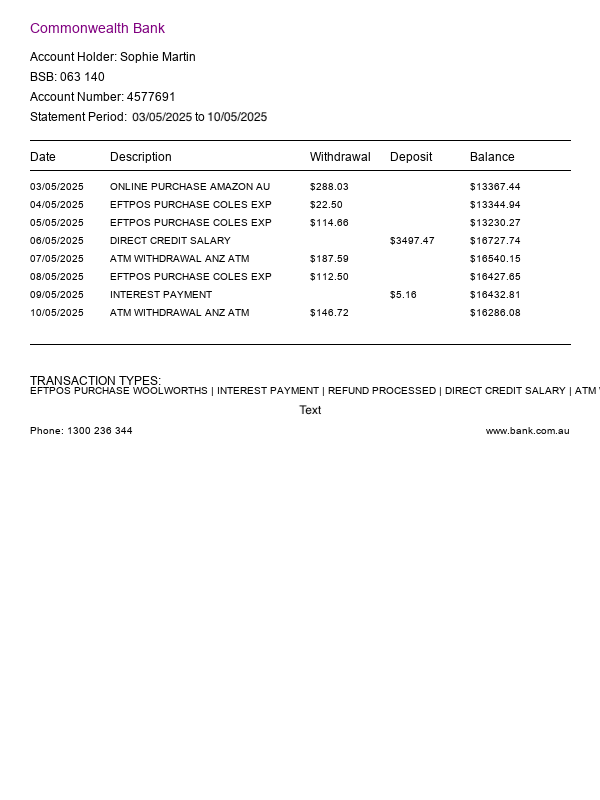

In [4]:
# Cell 4: Load bank statement image

imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_003.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_008.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_009.png"

print("📁 Loading image...")
image = Image.open(imageName).convert('RGB')

print(f"✅ Image loaded: {image.size}")
print("🖼️  Bank statement image:")
display(image)

# Bank Statement Extraction Protocol (2-Turn Balance-Description)
- Turn 0: Identify actual table headers
- Turn 1: Extract using balance-description prompt
- Python: Parse, filter, and extract schema fields

In [5]:
# Cell 5: Turn 0 - Identify table headers

turn0_prompt = """Look at the transaction table in this bank statement image.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3-8B...")

# Preprocess image
pixel_values = load_image(imageName, input_size=448)
pixel_values = pixel_values.to(dtype=model_dtype, device='cuda:0')

# Generate response using chat method
turn0_response = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=turn0_prompt,
    generation_config={'max_new_tokens': 500, 'do_sample': False}
)

# Free memory
del pixel_values
torch.cuda.empty_cache()

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(turn0_response)
print("=" * 60)

💬 TURN 0: Identifying actual table headers
🤖 Generating response with InternVL3-8B...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
The exact column header names used in the transaction table are:

1. Date
2. Description
3. Withdrawal
4. Deposit
5. Balance


In [6]:
# Cell 6: Parse headers from Turn 0 response

def parse_headers_from_response(response_text):
    """Parse column headers from Turn 0 response."""
    header_lines = [line.strip() for line in response_text.split('\n') if line.strip()]
    identified_headers = []
    
    for line in header_lines:
        cleaned = line.lstrip('0123456789.-•* ').strip()
        cleaned = cleaned.replace('**', '').replace('__', '')
        if cleaned.endswith(':'):
            continue
        if len(cleaned) > 40:
            continue
        if cleaned and len(cleaned) > 2:
            identified_headers.append(cleaned)
    
    return identified_headers

table_headers = parse_headers_from_response(turn0_response)

print(f"\n📋 Parsed {len(table_headers)} column headers:")
for i, header in enumerate(table_headers, 1):
    print(f"  {i}. '{header}'")

print(f"\n✅ Stored table_headers: {table_headers}")


📋 Parsed 5 column headers:
  1. 'Date'
  2. 'Description'
  3. 'Withdrawal'
  4. 'Deposit'
  5. 'Balance'

✅ Stored table_headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']


## Pattern Matching: Map Generic Concepts to Actual Headers

In [7]:
# Cell 7: Pattern Matching

DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'debits', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'credits', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords."""
    headers_lower = [h.lower() for h in headers]
    
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    for pattern in patterns:
        if len(pattern) > 2:
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback=None)

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")

has_balance = balance_col is not None and balance_col in table_headers
print(f"\n🎯 Balance column detected: {'✅ YES' if has_balance else '❌ NO'}")

if not has_balance:
    print("⚠️  WARNING: No balance column found.")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Description'
  Debit       → 'Withdrawal'
  Credit      → 'Deposit'
  Balance     → 'Balance'

🎯 Balance column detected: ✅ YES


## Turn 1: Balance-Description Extraction

In [8]:
# Cell 8: Generate extraction prompt

if has_balance:
    extraction_prompt = f"""List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND" """
    
    print("📝 TURN 1: Balance-Description Extraction")
    print("=" * 60)
    print("Extraction Prompt:")
    print(extraction_prompt)
    print("=" * 60)
else:
    print("❌ Cannot proceed - no balance column detected.")
    extraction_prompt = None

📝 TURN 1: Balance-Description Extraction
Extraction Prompt:
List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Description
- Withdrawal Amount or "NOT_FOUND"
- Deposit Amount or "NOT_FOUND" 


In [9]:
# Cell 9: Execute Turn 1 extraction

if extraction_prompt:
    print("🤖 Generating response with InternVL3-8B...")
    
    # Reload image for fresh context
    pixel_values = load_image(imageName, input_size=448)
    pixel_values = pixel_values.to(dtype=model_dtype, device='cuda:0')
    
    extraction_response = model.chat(
        tokenizer=tokenizer,
        pixel_values=pixel_values,
        question=extraction_prompt,
        generation_config={'max_new_tokens': 4096, 'do_sample': False}
    )
    
    # Free memory
    del pixel_values
    torch.cuda.empty_cache()
    
    print("\n✅ Turn 1 extraction complete!")
    print(f"\n📊 Response length: {len(extraction_response)} characters")
    print("\n" + "=" * 60)
    print("TURN 1 - BALANCE-DESCRIPTION EXTRACTION:")
    print("=" * 60)
    print(extraction_response)
    print("=" * 60)
else:
    extraction_response = None

🤖 Generating response with InternVL3-8B...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



✅ Turn 1 extraction complete!

📊 Response length: 1482 characters

TURN 1 - BALANCE-DESCRIPTION EXTRACTION:
Here are the balances listed with the corresponding dates, descriptions, withdrawal amounts, and deposit amounts:

1. **Date:** 03/05/2025  
   **Description:** ONLINE PURCHASE AMAZON AU  
   **Withdrawal Amount:** $288.03  
   **Deposit Amount:** NOT_FOUND  
   **Balance:** $13367.44

 2. **Date:** 04/05/2025  
   **Description:** EFTPOS PURCHASE COLES EXP  
   **Withdrawwal Amount:** $22.50  
   **Deposit Amount:** NOT_FOUND  
   **Balance:** $13344.94

 3. **Date:** 05/05/2025  
   **Description:** EFTPOS PURCHASE COLES EXP  
   **Withdrawwal Amount:** $114.66  
   **Deposit Amount:** NOT_FOUND  
   **Balance:** $13230.27

 4. **Date:** 06/05/2025  
   **Description:** DIRECT CREDIT SALARY  
   **Withdrawwal Amount:** NOT_FOUND  
   **Deposit Amount:** $33497.47  
   **Balance:** $16727.74

 5. **Date:** 07/05/2025  
   **Description:** ATM WITHDRAWAL ANZ ATM  
   **Withdraww

## Python Parsing: Balance-Description Response

In [ ]:
# Cell 10: Parse balance-description response

def parse_balance_description_response(response_text, date_col, desc_col, debit_col, credit_col, balance_col):
    """Parse the hierarchical balance-description response into transaction rows.

    Handles multiple output formats:
    - InternVL3: "1. **Date:** 03/05/2025" with "**Field:** value"
    - Llama: "**03/05/2025**" with "* Field: value"
    - Standard: "1. **date**" with "- Field: value"
    """
    rows = []
    current_date = None
    current_transaction = {}

    lines = response_text.strip().split("\n")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # ============================================================
        # DATE DETECTION PATTERNS
        # ============================================================
        date_found = None

        # Pattern 1: InternVL3 format "1. **Date:** 03/05/2025" or "**Date:** 03/05/2025"
        date_field_match = re.match(r"^\d*\.?\s*\*?\*?Date:?\*?\*?\s*(.+)$", line, re.IGNORECASE)
        if date_field_match:
            date_found = date_field_match.group(1).strip().strip('*').strip()

        # Pattern 2: Bold date header "**03/05/2025**" (Llama style)
        if not date_found:
            bold_date_match = re.match(r"^\*\*(\d{1,2}/\d{1,2}/\d{4})\*\*$", line)
            if bold_date_match:
                date_found = bold_date_match.group(1)

        # Pattern 3: Numbered bold date "1. **Thu 04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 4: Numbered date without day "1. **04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 5: Numbered DD/MM/YYYY "1. **03/05/2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}/\d{1,2}/\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        if date_found:
            # Save previous transaction if exists
            if current_transaction and current_date:
                current_transaction[date_col] = current_date
                rows.append(current_transaction)
                current_transaction = {}
            current_date = date_found
            continue

        # ============================================================
        # FIELD DETECTION PATTERNS
        # ============================================================
        field_name = None
        field_value = None

        # Pattern 1: "**Description:** value" (InternVL3 style)
        bold_field_match = re.match(r"^\s*\*\*([^*:]+)(?:\s*Amount)?:?\*\*\s*(.+)$", line, re.IGNORECASE)
        if bold_field_match:
            field_name = bold_field_match.group(1).strip().lower()
            field_value = bold_field_match.group(2).strip()

        # Pattern 2: "* Description: value" (Llama style with asterisk bullet)
        if not field_name:
            asterisk_field_match = re.match(r"^\s*\*\s*([^:]+):\s*(.+)$", line)
            if asterisk_field_match:
                field_name = asterisk_field_match.group(1).strip().lower()
                field_value = asterisk_field_match.group(2).strip()

        # Pattern 3: "- Description: value" (standard style)
        if not field_name:
            dash_field_match = re.match(r"^\s*-\s*([^:]+):\s*(.+)$", line)
            if dash_field_match:
                field_name = dash_field_match.group(1).strip().lower()
                field_value = dash_field_match.group(2).strip()

        if field_name and field_value:
            # Normalize field names (remove "amount" suffix, handle variants)
            field_name = field_name.replace(" amount", "").strip()

            # Map to appropriate column
            if field_name in ["description", "transaction", "details", "particulars", desc_col.lower()]:
                # If we already have a description, this is a new transaction under same date
                if desc_col in current_transaction and current_transaction[desc_col]:
                    if current_date:
                        current_transaction[date_col] = current_date
                    rows.append(current_transaction)
                    current_transaction = {}
                current_transaction[desc_col] = field_value

            elif field_name in ["debit", "withdrawal", "withdrawwal", "dr", debit_col.lower()]:
                current_transaction[debit_col] = field_value

            elif field_name in ["credit", "deposit", "cr", credit_col.lower()]:
                current_transaction[credit_col] = field_value

            elif field_name == "balance":
                current_transaction[balance_col] = field_value

            elif field_name == "amount":
                # Generic amount - put in debit by default
                if debit_col not in current_transaction:
                    current_transaction[debit_col] = field_value

    # Don't forget the last transaction
    if current_transaction and current_date:
        current_transaction[date_col] = current_date
        rows.append(current_transaction)

    return rows


def parse_markdown_table(markdown_text):
    """Fallback: Parse markdown table."""
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    headers = [h for h in header_parts if h]
    
    rows = []
    for line in lines[header_idx + 1:]:
        if '|' not in line:
            continue
        cleaned = line.replace('|', '').replace('-', '').replace(' ', '').replace(':', '')
        if not cleaned:
            continue
        value_parts = [v.strip() for v in line.split('|')]
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
    
    return rows


# Parse the extraction response
if extraction_response:
    all_rows = parse_balance_description_response(
        extraction_response, date_col, desc_col, debit_col, credit_col, balance_col
    )
    
    if not all_rows and "|" in extraction_response:
        print("⚠️  Fallback: parsing as markdown table")
        all_rows = parse_markdown_table(extraction_response)
    
    print(f"\n📊 Parsed {len(all_rows)} total rows")
    
    print("\n" + "=" * 60)
    print("PARSED TRANSACTIONS:")
    print("=" * 60)
    for i, row in enumerate(all_rows[:10]):
        print(f"\n{i+1}. {row}")
    if len(all_rows) > 10:
        print(f"\n... and {len(all_rows) - 10} more rows")
else:
    all_rows = []

## Filter for Debit Transactions

In [11]:
# Cell 11: Filter for debit transactions

def parse_amount(value):
    """Extract numeric value from formatted currency string."""
    if not value or value.strip() == "":
        return 0.0
    cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
    try:
        return float(cleaned)
    except ValueError:
        return 0.0


def is_non_transaction_row(row, desc_col):
    """Check if this row is NOT an actual transaction."""
    desc = row.get(desc_col, "").strip().upper()
    return any(x in desc for x in ["OPENING BALANCE", "CLOSING BALANCE", "BROUGHT FORWARD", "CARRIED FORWARD"])


def filter_debit_transactions(rows, debit_col, desc_col=None):
    """Filter rows to only those with actual debit transactions."""
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, "").strip()
        
        if not debit_value or debit_value.upper() == "NOT_FOUND":
            continue
        
        amount = parse_amount(debit_value)
        if amount <= 0:
            continue
        
        if desc_col and is_non_transaction_row(row, desc_col):
            continue
        
        debit_rows.append(row)
    
    return debit_rows


debit_rows = filter_debit_transactions(all_rows, debit_col, desc_col)

print(f"\n📊 Filtered to {len(debit_rows)} debit transactions")
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS ONLY:")
print("=" * 60)
for i, row in enumerate(debit_rows):
    date = row.get(date_col, "N/A")
    desc = row.get(desc_col, "N/A")
    amount = row.get(debit_col, "N/A")
    print(f"{i+1}. [{date}] {desc} - {amount}")


📊 Filtered to 0 debit transactions

DEBIT TRANSACTIONS ONLY:


## Extract Schema Fields

In [12]:
# Cell 12: Extract schema fields

def extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=None):
    """Extract fields in universal.yaml schema format."""
    if not debit_rows:
        return {
            "DOCUMENT_TYPE": "BANK_STATEMENT",
            "STATEMENT_DATE_RANGE": "NOT_FOUND",
            "TRANSACTION_DATES": "NOT_FOUND",
            "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
            "TRANSACTION_AMOUNTS_PAID": "NOT_FOUND",
        }
    
    debit_dates = [row.get(date_col, "").strip() for row in debit_rows if row.get(date_col)]
    descriptions = [row.get(desc_col, "").strip() for row in debit_rows if row.get(desc_col)]
    amounts = [row.get(debit_col, "").strip() for row in debit_rows if row.get(debit_col)]
    
    rows_for_range = all_rows if all_rows is not None else debit_rows
    all_dates = [row.get(date_col, "").strip() for row in rows_for_range if row.get(date_col)]
    date_range = f"{all_dates[0]} - {all_dates[-1]}" if all_dates else "NOT_FOUND"
    
    return {
        "DOCUMENT_TYPE": "BANK_STATEMENT",
        "STATEMENT_DATE_RANGE": date_range,
        "TRANSACTION_DATES": " | ".join(debit_dates) if debit_dates else "NOT_FOUND",
        "LINE_ITEM_DESCRIPTIONS": " | ".join(descriptions) if descriptions else "NOT_FOUND",
        "TRANSACTION_AMOUNTS_PAID": " | ".join(amounts) if amounts else "NOT_FOUND",
    }


schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=all_rows)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS:")
print("=" * 60)
for field, value in schema_fields.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"\n{field}:")
    print(f"  {display_value}")


EXTRACTED SCHEMA FIELDS:

DOCUMENT_TYPE:
  BANK_STATEMENT

STATEMENT_DATE_RANGE:
  NOT_FOUND

TRANSACTION_DATES:
  NOT_FOUND

LINE_ITEM_DESCRIPTIONS:
  NOT_FOUND

TRANSACTION_AMOUNTS_PAID:
  NOT_FOUND


In [ ]:
# Cell 13: Load Ground Truth and Evaluate (using batch_v2 metrics)

import pandas as pd
from pathlib import Path
from dateutil import parser as date_parser

# Import evaluation metrics from common module (same as batch_v2 scripts)
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    calculate_field_accuracy_f1_position_agnostic,
    calculate_field_accuracy_kieval,
    calculate_correlation_aware_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate (same as batch_v2)
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Ground truth configuration
GROUND_TRUTH_PATH = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv"

# Evaluation method: "order_aware_f1", "position_agnostic_f1", "kieval", or "correlation"
EVALUATION_METHOD = "order_aware_f1"

# ============================================================================
# SEMANTIC NORMALIZATION (same as batch_v2)
# ============================================================================
def normalize_date(date_str):
    """Normalize date string to canonical format YYYY-MM-DD for semantic comparison."""
    if not date_str or pd.isna(date_str):
        return ""
    date_str = str(date_str).strip()
    if not date_str:
        return ""
    try:
        parsed = date_parser.parse(date_str, dayfirst=True)
        return parsed.strftime("%Y-%m-%d")
    except (ValueError, TypeError):
        return date_str


def normalize_amount(amount_str):
    """Normalize amount string for semantic comparison."""
    if not amount_str or pd.isna(amount_str):
        return ""
    amount_str = str(amount_str).strip()
    if not amount_str:
        return ""
    # Remove currency symbols and whitespace
    cleaned = re.sub(r"[$£€¥₹\s]", "", amount_str)
    cleaned = cleaned.replace(",", "")
    try:
        value = float(cleaned)
        value = abs(value)  # Ignore sign for matching
        return f"{value:.2f}".rstrip("0").rstrip(".")
    except ValueError:
        return cleaned


def normalize_pipe_delimited(value, normalizer_fn):
    """Apply normalizer function to each item in a pipe-delimited string."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if not value:
        return ""
    items = [item.strip() for item in value.split("|")]
    normalized = [normalizer_fn(item) for item in items]
    return " | ".join(normalized)


def normalize_field_for_comparison(field_name, value):
    """Normalize a field value based on its type for semantic comparison."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if field_name == "TRANSACTION_DATES":
        return normalize_pipe_delimited(value, normalize_date)
    elif field_name == "TRANSACTION_AMOUNTS_PAID":
        return normalize_pipe_delimited(value, normalize_amount)
    elif field_name == "STATEMENT_DATE_RANGE":
        if " - " in value:
            parts = value.split(" - ")
            if len(parts) == 2:
                start = normalize_date(parts[0].strip())
                end = normalize_date(parts[1].strip())
                return f"{start} - {end}"
        return value
    else:
        return value


# ============================================================================
# EVALUATION FUNCTIONS (same as batch_v2)
# ============================================================================
def evaluate_field(extracted_value, gt_value, field_name, method):
    """Route to appropriate evaluation function."""
    if method == "order_aware_f1":
        return calculate_field_accuracy_f1(extracted_value, gt_value, field_name)
    elif method == "position_agnostic_f1":
        return calculate_field_accuracy_f1_position_agnostic(extracted_value, gt_value, field_name)
    elif method == "kieval":
        return calculate_field_accuracy_kieval(extracted_value, gt_value, field_name)
    elif method == "correlation":
        return None
    else:
        raise ValueError(f"Unknown evaluation method: {method}")


def evaluate_extraction(schema_fields, image_name, ground_truth_map, method):
    """Evaluate extracted schema fields against ground truth."""
    gt_data = ground_truth_map.get(image_name, {})
    
    if not gt_data:
        return {"error": "No ground truth found", "image_name": image_name}
    
    if method == "correlation":
        normalized_extracted = {
            field: normalize_field_for_comparison(field, schema_fields.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        normalized_gt = {
            field: normalize_field_for_comparison(field, gt_data.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        result = calculate_correlation_aware_f1(
            extracted_data=normalized_extracted,
            ground_truth_data=normalized_gt,
            document_type="bank_statement",
            debug=False,
        )
        return {
            "image_name": image_name,
            "method": method,
            "overall_accuracy": result.get("combined_f1", 0.0),
            "standard_f1": result.get("standard_f1", 0.0),
            "alignment_score": result.get("alignment_score", 0.0),
            "field_scores": result.get("field_f1_scores", {}),
        }
    
    field_scores = {}
    total_f1 = 0.0
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_value = schema_fields.get(field, "NOT_FOUND")
        gt_value = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(gt_value):
            gt_value = "NOT_FOUND"
        
        normalized_extracted = normalize_field_for_comparison(field, extracted_value)
        normalized_gt = normalize_field_for_comparison(field, gt_value)
        
        result = evaluate_field(normalized_extracted, normalized_gt, field, method)
        
        if result:
            field_scores[field] = {
                "f1_score": result.get("f1_score", 0.0),
                "precision": result.get("precision", 0.0),
                "recall": result.get("recall", 0.0),
                "extracted": str(extracted_value)[:100],
                "ground_truth": str(gt_value)[:100],
            }
            total_f1 += result.get("f1_score", 0.0)
    
    overall_accuracy = total_f1 / len(BANK_STATEMENT_FIELDS) if BANK_STATEMENT_FIELDS else 0.0
    
    return {
        "image_name": image_name,
        "method": method,
        "overall_accuracy": overall_accuracy,
        "field_scores": field_scores,
    }


def display_field_comparison(schema_fields, ground_truth_map, image_name, eval_result):
    """Display stacked comparison of extracted vs ground truth fields."""
    gt_data = ground_truth_map.get(image_name, {})
    field_scores = eval_result.get("field_scores", {})
    
    print("\n" + "=" * 90)
    print(f"📊 FIELD COMPARISON ({EVALUATION_METHOD}) - {image_name}")
    print("=" * 90)
    
    print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
    print("-" * 90)
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        ground_val = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(ground_val):
            ground_val = "NOT_FOUND"
        
        if isinstance(field_scores.get(field), dict):
            f1_score = field_scores[field].get("f1_score", 0.0)
            precision = field_scores[field].get("precision", 0.0)
            recall = field_scores[field].get("recall", 0.0)
        else:
            f1_score = field_scores.get(field, 0.0)
            precision = 0.0
            recall = 0.0
        
        if f1_score == 1.0:
            status = "✅ OK"
        elif f1_score >= 0.5:
            status = "⚠️ PART"
        else:
            status = "❌ FAIL"
        
        print(f"{status:<8} {field:<30} {f1_score:>7.1%} {precision:>7.1%} {recall:>7.1%}")
    
    print("-" * 90)
    
    # Show detailed values
    print("\n📋 DETAILED VALUES:")
    print("-" * 90)
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        gt_val = gt_data.get(field, "NOT_FOUND")
        if pd.isna(gt_val):
            gt_val = "NOT_FOUND"
        
        print(f"\n{field}:")
        print(f"  Extracted:    {str(extracted_val)[:80]}{'...' if len(str(extracted_val)) > 80 else ''}")
        print(f"  Ground Truth: {str(gt_val)[:80]}{'...' if len(str(gt_val)) > 80 else ''}")


# ============================================================================
# RUN EVALUATION
# ============================================================================
print("📁 Loading ground truth...")
ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)

# Get image filename for lookup
image_filename = Path(imageName).name
print(f"\n🔍 Looking up ground truth for: {image_filename}")

# Add DOCUMENT_TYPE to schema_fields if not present
if "DOCUMENT_TYPE" not in schema_fields:
    schema_fields["DOCUMENT_TYPE"] = "BANK_STATEMENT"

# Check if ground truth exists for this image
if image_filename in ground_truth_map:
    print(f"✅ Ground truth found!")
    
    # Evaluate using batch_v2 metrics
    eval_result = evaluate_extraction(schema_fields, image_filename, ground_truth_map, EVALUATION_METHOD)
    
    # Display comparison
    display_field_comparison(schema_fields, ground_truth_map, image_filename, eval_result)
    
    overall_f1 = eval_result.get("overall_accuracy", 0.0)
    
    print("\n" + "=" * 90)
    print(f"📊 OVERALL F1 SCORE ({EVALUATION_METHOD}): {overall_f1:.1%}")
    print("=" * 90)
else:
    print(f"⚠️  No ground truth found for: {image_filename}")
    print(f"   Available images: {list(ground_truth_map.keys())[:5]}...")
    overall_f1 = None

In [ ]:
# Cell 14: Summary

print("\n" + "=" * 60)
print("📊 EXTRACTION SUMMARY")
print("=" * 60)
print(f"\n🔧 Method: 2-Turn Balance-Description")
print(f"📋 Headers detected: {len(table_headers)}")
print(f"💰 Balance column: {balance_col}")
print(f"📝 Total transactions parsed: {len(all_rows)}")
print(f"💸 Debit transactions: {len(debit_rows)}")
if 'overall_f1' in dir():
    print(f"📊 Overall F1 Score: {overall_f1:.1%}")
print(f"\n✅ Pipeline complete!")